In [1]:
import json
import torch
import dataset
import utils
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

/Users/anton/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/anton/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
configs = json.load(open('configs.json'))
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [3]:
train_dataset = dataset.RoadSignDataset(configs['train_label_path'], configs['train_folder_path'], pad_shape=configs['pad_shape'])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=configs['train_batch_size'], shuffle=configs['shuffle'])

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [4]:
val_dataset = dataset.RoadSignDataset(configs['val_label_path'], configs['val_folder_path'], pad_shape=configs['pad_shape'])

# val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=configs['train_batch_size'], shuffle=configs['shuffle'])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
model = smp.Unet('resnet18', encoder_weights='imagenet', in_channels=3, classes=1,activation='sigmoid')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=configs['init_lr'])
loss = torch.nn.BCELoss()

In [6]:
epoch_num = configs['epochs']
show_loss = []
for epoch in range(epoch_num):
    for i, (images, masks) in enumerate(train_dataloader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss_value = loss(output, masks)
        show_loss.append(loss_value.item())
        loss_value.backward()
        optimizer.step()
        del images, masks
    print(f'epoch: {epoch}, loss: {np.mean(show_loss)}')    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


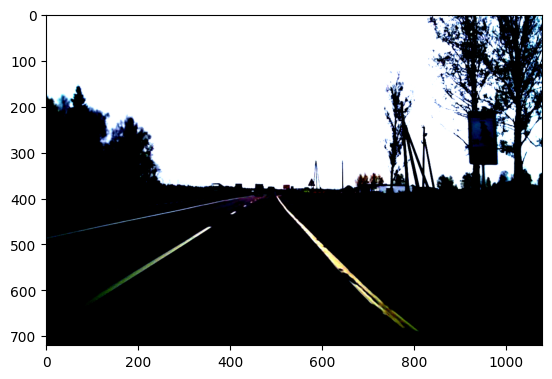

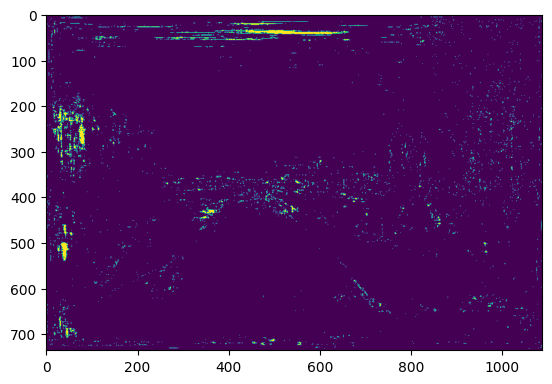

In [ ]:
test_image = utils.load_transformed_image('sign_dataset/val/203.jpg').unsqueeze(0).to(device)
pad_transorm = torch.nn.ZeroPad2d(configs['pad_shape'])
with torch.no_grad():
    pred = model(pad_transorm(test_image))
    pred = pred.squeeze().cpu().detach().numpy()
    plt.imshow(test_image.squeeze().permute(1, 2, 0))
    plt.show()
    plt.imshow(np.round(pred))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


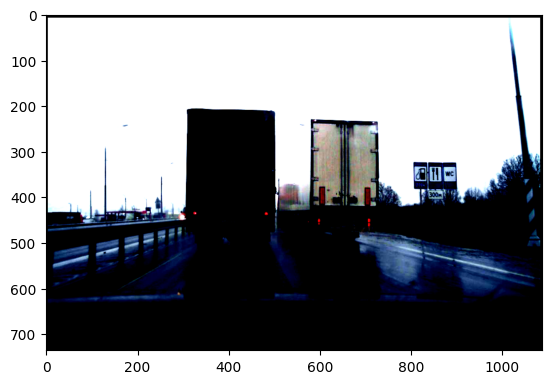

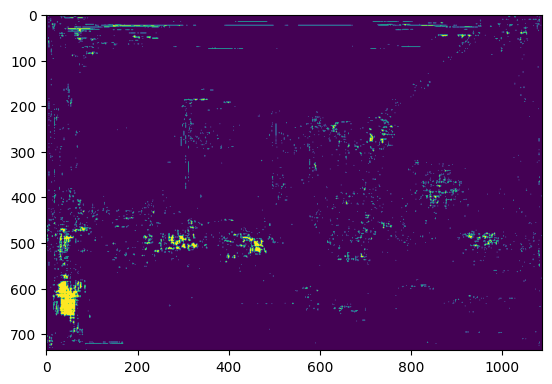

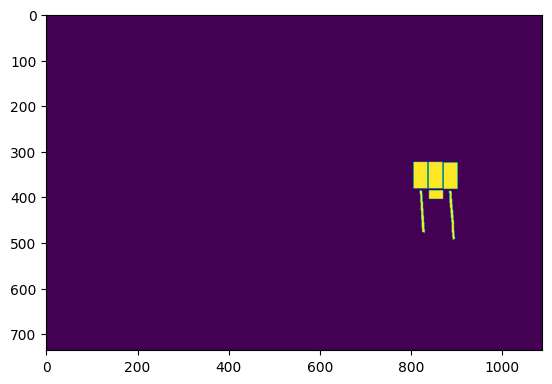

In [ ]:
test_image, mask = val_dataset[0]
with torch.no_grad():
    pred = model(test_image[None, :,:,:])
    pred = pred.squeeze().cpu().detach().numpy()
    plt.imshow(test_image.squeeze().permute(1, 2, 0))
    plt.show()
    plt.imshow(np.round(pred))
    plt.show()

    plt.imshow(mask.squeeze())
    plt.show()